# Librerías

In [ ]:
import pandas as pd
import numpy as np
from plotly import graph_objects as go
import matplotlib.pyplot as plt

# Archivo de datos

In [ ]:
logs = pd.read_csv('/datasets/logs_exp_us.csv', engine='python', sep='\s')

# Paso 2. Preparar los datos para el análisis

In [ ]:
logs

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [ ]:
logs.columns = ['event_name', 'user_id','full_date','group']

In [ ]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   event_name  244126 non-null  object
 1   user_id     244126 non-null  int64 
 2   full_date   244126 non-null  int64 
 3   group       244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [ ]:
logs.duplicated().sum()

np.int64(413)

In [ ]:
logs.drop_duplicates(inplace=True)
logs.reset_index(inplace= True, drop = True)

In [ ]:
logs.duplicated().sum()

np.int64(0)

In [ ]:
logs['full_date'] = pd.to_datetime(logs['full_date'], unit = 's')
logs.head(1)

,event_name,user_id,full_date,group
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246


In [ ]:
logs['date'] = logs['full_date'].dt.date
logs['time'] = logs['full_date'].dt.time

In [ ]:
logs.head()

,event_name,user_id,full_date,group,date,time
0,MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25,04:43:36
1,MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25,11:11:42
2,PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
3,CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25,11:28:47
4,PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25,11:48:42


In [ ]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   full_date   243713 non-null  datetime64[ns]
 3   group       243713 non-null  int64         
 4   date        243713 non-null  object        
 5   time        243713 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 11.2+ MB


En la preparación de los datos se hizo el cambio de nombre de las columnas, se eliminaron 413 duplicados, el cual son pocos en comparación al número total de datos. También se cambió el tipo de dato a la columna 'full_date' y se dividió en fecha y hora.

# Paso 3. Estudiar y comprobar los datos

## 3.1 ¿Cuántos eventos hay en los registros?

In [ ]:
print(logs['event_name'].nunique())
print(logs['event_name'].unique())

5
['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']


## 3.2 ¿Cuántos usuarios hay en los registros?

In [ ]:
logs['user_id'].nunique()

7551

## 3.3 ¿Cuál es el promedio de eventos por usuario?

In [ ]:
events = logs.groupby('group')['event_name'].count().reset_index()
users = logs.groupby('group')['user_id'].nunique().reset_index()

In [ ]:
events_per_user = events.merge(users, on = 'group')
events_per_user['avg_events_per_user'] = events_per_user['event_name'] / events_per_user['user_id']
events_per_user

,group,event_name,user_id,avg_events_per_user
0,246,80181,2489,32.214142
1,247,77950,2520,30.932540
2,248,85582,2542,33.667191


## 3.4 ¿Qué periodo de tiempo cubren los datos?

In [ ]:
print(logs['date'].min(), logs['date'].max())

2019-07-25 2019-08-07


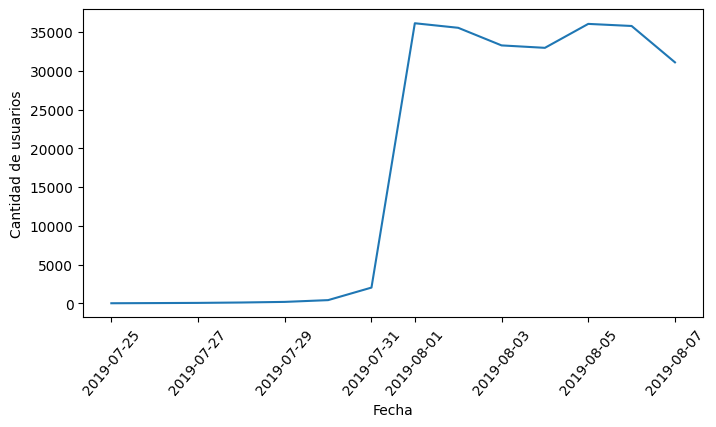

In [ ]:
plt.figure(figsize=(8,4))
logs.groupby('date')['user_id'].count().plot()
plt.ylabel('Cantidad de usuarios')
plt.xlabel('Fecha')
plt.xticks(rotation=50)
plt.show()

## 3.5 ¿Perdiste muchos eventos y usuarios al excluir los datos más antiguos?

In [ ]:
logs_filtrados = logs[logs['date'] > pd.to_datetime('2019-07-30').date()]

In [ ]:
logs_filtrados['user_id'].nunique() / logs['user_id'].nunique()

0.99880810488677

## 3.6 Asegúrate de tener usuarios de los tres grupos experimentales.

In [ ]:
logs_filtrados.groupby('group')['user_id'].nunique()

,user_id
group,
246,2485
247,2517
248,2540


Los datos completos empiezan desde el día 2019-07-30, por lo que se excluirán fechas anteriores. Este cambio no representa una gran pérdida de información y los 3 grupos aún cuentan con una cantidad similar de usuarios.

# Paso 4. Estudiar el embudo de eventos

## 4.1 Observa qué eventos hay en los registros y su frecuencia de suceso. Ordénalos por frecuencia.

In [ ]:
logs_filtrados.groupby('event_name')['user_id'].count().sort_values(ascending = False)

,user_id
event_name,
MainScreenAppear,118578
OffersScreenAppear,46707
CartScreenAppear,42560
PaymentScreenSuccessful,34058
Tutorial,1014


## 4.2 Encuentra la cantidad de usuarios que realizaron cada una de estas acciones. Ordena los eventos por el número de usuarios. Calcula la proporción de usuarios que realizaron la acción al menos una vez.

In [ ]:
logs_filtrados.groupby('event_name')['user_id'].nunique().sort_values(ascending = False)

,user_id
event_name,
MainScreenAppear,7429
OffersScreenAppear,4606
CartScreenAppear,3742
PaymentScreenSuccessful,3542
Tutorial,845


## 4.3 ¿En qué orden crees que ocurrieron las acciones? ¿Todas son parte de una sola secuencia?

4 de los eventos ocurrieron en el orden mostrado previamente, exceptuando el Tutorial, ya que este es un paso opcional.

## 4.4 Utiliza el embudo de eventos para encontrar la proporción de usuarios que pasan de una etapa a la siguiente. Por ejemplo, para la secuencia de eventos A → B → C, calcula la proporción de usuarios en la etapa B a la cantidad de usuarios en la etapa A y la proporción de usuarios en la etapa C a la cantidad en la etapa B.

In [ ]:
user_by_event = logs_filtrados.groupby('event_name')['user_id'].nunique().sort_values(ascending = False).reset_index()
user_by_event['users_in_ps'] = user_by_event['user_id'].shift(1)
user_by_event['cr_ps'] = user_by_event['user_id'] / user_by_event['users_in_ps']
user_by_event['dropoff_rate'] = 1 - user_by_event['cr_ps']

user_by_event.fillna(0, inplace = True)
user_by_event

,event_name,user_id,users_in_ps,cr_ps,dropoff_rate
0,MainScreenAppear,7429,0.0,0.000000,0.000000
1,OffersScreenAppear,4606,7429.0,0.620003,0.379997
2,CartScreenAppear,3742,4606.0,0.812419,0.187581
3,PaymentScreenSuccessful,3542,3742.0,0.946553,0.053447
4,Tutorial,845,3542.0,0.238566,0.761434


In [ ]:
fig = go.Figure(go.Funnel(
    y = ['MainScreenAppear', 'OffersScreenAppear', 'CartScreenAppear','PaymentScreenSuccessful'],
    x = [7429, 4606, 3742, 3542],
    textinfo = "value+percent initial"
))

fig.show()

## 4.5 ¿En qué etapa pierdes más usuarios?

Se puede apreciar en el cálculo y embudo anterior que una gran cantidad de usuarios abandonan antes de pasar al segundo evento y esta proporción es mayor a la de las demás etapas.

## 4.6 ¿Qué porcentaje de usuarios hace todo el viaje desde su primer evento hasta el pago?

La cantidad de usuarios que llega hasta el pago es del 47.7%.

# Paso 5. Estudiar los resultados del experimento

## ¿Cuántos usuarios hay en cada grupo?

In [ ]:
logs_filtrados.groupby('group')['user_id'].nunique()

,user_id
group,
246,2485
247,2517
248,2540


## Tenemos dos grupos de control en el test A/A, donde comprobamos nuestros mecanismos y cálculos. Observa si hay una diferencia estadísticamente significativa entre las muestras 246 y 247.

In [ ]:
control_groups = logs_filtrados.copy()
groups = [246, 247]
control_groups = control_groups[control_groups['group'].isin(groups)]

### Evento más popular y cantidad de usuarios que realizaron cada acción.

In [ ]:
count = control_groups.groupby(['event_name', 'group'])['user_id'].nunique().unstack(fill_value=0).sort_values(by=246, ascending=False)

count

group,246,247
event_name,,
MainScreenAppear,2452,2479
OffersScreenAppear,1544,1526
CartScreenAppear,1267,1239
PaymentScreenSuccessful,1200,1159
Tutorial,278,285


### Proporción de cada evento y verificación de la diferencia entre los grupos.

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

total = count.loc['MainScreenAppear']
results = []

for event in count.index:
    group_246 = count.loc[event, 246]
    group_247 = count.loc[event, 247]

    total_246 = total[246]
    total_247 = total[247]

    prop_246 = group_246 / total_246
    prop_247 = group_247 / total_247

    z_stat, pval = proportions_ztest([group_246, group_247], [total_246, total_247])

    results.append({
        'event': event,
        'users_246': group_246,
        'users_247': group_247,
        'proportion_246': round(prop_246, 4),
        'proportion_247': round(prop_247, 4),
        'z_stat': round(z_stat, 3),
        'p_value': round(pval, 3),
        'significativo': 'Sí' if pval < 0.1 else 'No'
    })

results_control = pd.DataFrame(results)
results_control = results_control.fillna(0).sort_values(by=['users_246', 'users_247'], ascending=False)

results_control

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning:

invalid value encountered in scalar divide



,event,users_246,users_247,proportion_246,proportion_247,z_stat,p_value,significativo
0,MainScreenAppear,2452,2479,1.0000,1.0000,0.000,0.000,No
1,OffersScreenAppear,1544,1526,0.6297,0.6156,1.023,0.306,No
2,CartScreenAppear,1267,1239,0.5167,0.4998,1.188,0.235,No
3,PaymentScreenSuccessful,1200,1159,0.4894,0.4675,1.537,0.124,No
4,Tutorial,278,285,0.1134,0.1150,-0.175,0.861,No


No hay diferencias estadísticamente significativas entre los grupos de control 246 y 247, además la diferencia entre cantidad de usuarios son mínimas y las proporciones son casi idénticas, lo que sugiere que ambos grupos se dividieron correctamente.

## Cálculo del grupo con fuentes alteradas. ¿Qué conclusiones puedes sacar del experimento?

In [ ]:
logs_filtrados.head(3)

,event_name,user_id,full_date,group,date,time
796,MainScreenAppear,3670880358399219515,2019-07-31 01:11:46,247,2019-07-31,01:11:46
797,OffersScreenAppear,3799109751993694887,2019-07-31 01:21:04,248,2019-07-31,01:21:04
798,Tutorial,1126021718529336913,2019-07-31 01:32:11,247,2019-07-31,01:32:11


In [ ]:
logs_filtrados.groupby(['event_name', 'group'])['user_id'].nunique().unstack(fill_value=0).sort_values(by=246, ascending=False)

group,246,247,248
event_name,,,
MainScreenAppear,2452,2479,2498
OffersScreenAppear,1544,1526,1536
CartScreenAppear,1267,1239,1236
PaymentScreenSuccessful,1200,1159,1183
Tutorial,278,285,282


# 246 vs 248

In [ ]:
test_group = 248
control_group = 246

subset = logs_filtrados[logs_filtrados['group'].isin([test_group, control_group])]

count = subset.groupby(['event_name', 'group'])['user_id'].nunique().unstack(fill_value=0)

total = count.loc['MainScreenAppear']
results = []

for evento in count.index:
    test_users = count.loc[evento, test_group]
    control_users = count.loc[evento, control_group]

    total_test = total[test_group]
    total_control = total[control_group]

    prop_test = test_users / total_test
    prop_control = control_users / total_control

    z_stat, pval = proportions_ztest([control_users, test_users], [total_control, total_test])

    results.append({
        'event': evento,
        'users_control': control_users,
        'users_test': test_users,
        'proportion_control': round(prop_control, 4),
        'proportion_test': round(prop_test, 4),
        'z_stat': round(z_stat, 3),
        'p_value': round(pval, 3),
        'significativo': 'Sí' if pval < 0.1 else 'No'
    })

results_248_vs_246 = pd.DataFrame(results).fillna(0).sort_values(by='users_test', ascending=False)
results_248_vs_246


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning:

invalid value encountered in scalar divide



,event,users_control,users_test,proportion_control,proportion_test,z_stat,p_value,significativo
1,MainScreenAppear,2452,2498,1.0000,1.0000,0.000,0.000,No
2,OffersScreenAppear,1544,1536,0.6297,0.6149,1.074,0.283,No
0,CartScreenAppear,1267,1236,0.5167,0.4948,1.543,0.123,No
3,PaymentScreenSuccessful,1200,1183,0.4894,0.4736,1.114,0.265,No
4,Tutorial,278,282,0.1134,0.1129,0.054,0.957,No


# 247 vs 248

In [ ]:
test_group = 248
control_group = 247

subset = logs_filtrados[logs_filtrados['group'].isin([test_group, control_group])]

count = subset.groupby(['event_name', 'group'])['user_id'].nunique().unstack(fill_value=0)

total = count.loc['MainScreenAppear']
results = []

for event in count.index:
    test_users = count.loc[event, test_group]
    control_users = count.loc[event, control_group]

    total_test = total[test_group]
    total_control = total[control_group]

    prop_test = test_users / total_test
    prop_control = control_users / total_control

    z_stat, pval = proportions_ztest([control_users, test_users], [total_control, total_test])

    results.append({
        'event': event,
        'users_control': control_users,
        'users_test': test_users,
        'proportion_control': round(prop_control, 4),
        'proportion_test': round(prop_test, 4),
        'z_stat': round(z_stat, 3),
        'p_value': round(pval, 3),
        'significativo': 'Sí' if pval < 0.1 else 'No'
    })

results_248_vs_247 = pd.DataFrame(results).fillna(0).sort_values(by='users_test', ascending=False)
results_248_vs_247


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning:

invalid value encountered in scalar divide



,event,users_control,users_test,proportion_control,proportion_test,z_stat,p_value,significativo
1,MainScreenAppear,2479,2498,1.0000,1.0000,0.000,0.000,No
2,OffersScreenAppear,1526,1536,0.6156,0.6149,0.049,0.961,No
0,CartScreenAppear,1239,1236,0.4998,0.4948,0.353,0.724,No
3,PaymentScreenSuccessful,1159,1183,0.4675,0.4736,-0.428,0.669,No
4,Tutorial,285,282,0.1150,0.1129,0.230,0.818,No


# 246 & 247 vs 248

In [ ]:
test_group = 248
control_groups = [246, 247]

subset = logs_filtrados[logs_filtrados['group'].isin(control_groups + [test_group])].copy()

subset['group'] = subset['group'].replace({246: 'control', 247: 'control', 248: 'test'})

count = subset.groupby(['event_name', 'group'])['user_id'].nunique().unstack(fill_value=0)

total = count.loc['MainScreenAppear']
results = []

for event in count.index:
    test_users = count.loc[event, 'test']
    control_users = count.loc[event, 'control']

    total_test = total['test']
    total_control = total['control']

    prop_test = test_users / total_test
    prop_control = control_users / total_control

    z_stat, pval = proportions_ztest([control_users, test_users], [total_control, total_test])

    results.append({
        'event': event,
        'users_control': control_users,
        'users_test': test_users,
        'proportion_control': round(prop_control, 4),
        'proportion_test': round(prop_test, 4),
        'z_stat': round(z_stat, 3),
        'p_value': round(pval, 3),
        'significativo': 'Sí' if pval < 0.1 else 'No'
    })

results_248_vs_control_combo = pd.DataFrame(results).fillna(0).sort_values(by='users_test', ascending=False)
results_248_vs_control_combo


/usr/local/lib/python3.11/dist-packages/statsmodels/stats/weightstats.py:792: RuntimeWarning:

invalid value encountered in scalar divide



,event,users_control,users_test,proportion_control,proportion_test,z_stat,p_value,significativo
1,MainScreenAppear,4931,2498,1.0000,1.0000,0.000,0.000,No
2,OffersScreenAppear,3070,1536,0.6226,0.6149,0.646,0.518,No
0,CartScreenAppear,2506,1236,0.5082,0.4948,1.093,0.275,No
3,PaymentScreenSuccessful,2359,1183,0.4784,0.4736,0.393,0.694,No
4,Tutorial,563,282,0.1142,0.1129,0.165,0.869,No


No hay diferencias estadísticamente significativas entre el grupo 248 y los controles, tanto de forma individual como combinada.

## ¿Qué nivel de significancia has establecido para probar las hipótesis estadísticas mencionadas anteriormente? Calcula cuántas pruebas de hipótesis estadísticas has realizado. Con un nivel de significancia estadística de 0.1, uno de cada 10 resultados podría ser falso. ¿Cuál debería ser el nivel de significancia? Si deseas cambiarlo, vuelve a ejecutar los pasos anteriores y comprueba tus conclusiones.

In [ ]:
results_all = pd.concat([
    results_248_vs_246.assign(comparison='248_vs_246'),
    results_248_vs_247.assign(comparison='248_vs_247'),
    results_248_vs_control_combo.assign(comparison='248_vs_control_combo')
])
results_all

,event,users_control,users_test,proportion_control,proportion_test,z_stat,p_value,significativo,comparison
1,MainScreenAppear,2452,2498,1.0000,1.0000,0.000,0.000,No,248_vs_246
2,OffersScreenAppear,1544,1536,0.6297,0.6149,1.074,0.283,No,248_vs_246
0,CartScreenAppear,1267,1236,0.5167,0.4948,1.543,0.123,No,248_vs_246
3,PaymentScreenSuccessful,1200,1183,0.4894,0.4736,1.114,0.265,No,248_vs_246
4,Tutorial,278,282,0.1134,0.1129,0.054,0.957,No,248_vs_246
1,MainScreenAppear,2479,2498,1.0000,1.0000,0.000,0.000,No,248_vs_247
2,OffersScreenAppear,1526,1536,0.6156,0.6149,0.049,0.961,No,248_vs_247
0,CartScreenAppear,1239,1236,0.4998,0.4948,0.353,0.724,No,248_vs_247
3,PaymentScreenSuccessful,1159,1183,0.4675,0.4736,-0.428,0.669,No,248_vs_247
4,Tutorial,285,282,0.1150,0.1129,0.230,0.818,No,248_vs_247


In [ ]:
from statsmodels.stats.multitest import multipletests

# Aplicar Benjamini-Hochberg con alpha = 0.1
rej, pvals_corrected, _, _ = multipletests(results_all['p_value'], alpha=0.1, method='fdr_bh')

# Añadir los resultados al DataFrame
results_all['p_value_corrected'] = pvals_corrected
results_all['significativo_BH'] = ['Sí' if r else 'No' for r in rej]

# Ordenar por evento o comparación si quieres
results_all = results_all.sort_values(by='p_value_corrected')

results_all

,event,users_control,users_test,proportion_control,proportion_test,z_stat,p_value,significativo,comparison,p_value_corrected,significativo_BH
1,MainScreenAppear,2452,2498,1.0000,1.0000,0.000,0.000,No,248_vs_246,0.000000,Sí
1,MainScreenAppear,2479,2498,1.0000,1.0000,0.000,0.000,No,248_vs_247,0.000000,Sí
1,MainScreenAppear,4931,2498,1.0000,1.0000,0.000,0.000,No,248_vs_control_combo,0.000000,Sí
0,CartScreenAppear,1267,1236,0.5167,0.4948,1.543,0.123,No,248_vs_246,0.461250,No
3,PaymentScreenSuccessful,1200,1183,0.4894,0.4736,1.114,0.265,No,248_vs_246,0.606429,No
2,OffersScreenAppear,1544,1536,0.6297,0.6149,1.074,0.283,No,248_vs_246,0.606429,No
0,CartScreenAppear,2506,1236,0.5082,0.4948,1.093,0.275,No,248_vs_control_combo,0.606429,No
4,Tutorial,278,282,0.1134,0.1129,0.054,0.957,No,248_vs_246,0.961000,No
0,CartScreenAppear,1239,1236,0.4998,0.4948,0.353,0.724,No,248_vs_247,0.961000,No
2,OffersScreenAppear,1526,1536,0.6156,0.6149,0.049,0.961,No,248_vs_247,0.961000,No


In [ ]:
!pip install multipy


  Preparing metadata (setup.py) ... done
  Created wheel for multipy: filename=multipy-0.16-py3-none-any.whl size=41430 sha256=d912d4c119ed557eb55a427582a2fc16fbbce2ceab9d346b9427d743e418250e
  Stored in directory: /root/.cache/pip/wheels/e5/44/1c/036742de5183900fc8e0c933f77321f34e68b28d00864e397f
Successfully built multipy


In [ ]:
pval = results_all[['comparison', 'event', 'p_value']]
pval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 15 entries, 1 to 4
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   comparison  15 non-null     object 
 1   event       15 non-null     object 
 2   p_value     15 non-null     float64
dtypes: float64(1), object(2)
memory usage: 480.0+ bytes


In [ ]:
pvals = results_all['p_value'].values

In [ ]:
from multipy.fdr import lsu

pval['Hypothesis Correction Result'] = lsu(pvals, q = 0.05)
pval.sort_values(by='p_value')

<ipython-input-79-3f9c0e9177af>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,comparison,event,p_value,Hypothesis Correction Result
1,248_vs_246,MainScreenAppear,0.000,True
1,248_vs_247,MainScreenAppear,0.000,True
1,248_vs_control_combo,MainScreenAppear,0.000,True
0,248_vs_246,CartScreenAppear,0.123,False
3,248_vs_246,PaymentScreenSuccessful,0.265,False
0,248_vs_control_combo,CartScreenAppear,0.275,False
2,248_vs_246,OffersScreenAppear,0.283,False
2,248_vs_control_combo,OffersScreenAppear,0.518,False
3,248_vs_247,PaymentScreenSuccessful,0.669,False
3,248_vs_control_combo,PaymentScreenSuccessful,0.694,False


Se realizaron 15 pruebas de hipótesis (3 comparaciones x 5 eventos). Se había establecido en un inicio, un nivel de significancia estadística del 0.1 y se realizó una corrección con el método de Benjamini-Hochberg (α = 0.05), sin embargo todos los p_value son superiores a 0.12 por lo que no habría ninguna diferencia.

La única diferencia significativa es la del evento MainScreenAppear la cual tiene un p_value de 0.000 y una proporción del 100% en todos los grupos (control y test) porque es el punto de entrada.

En conclusión, los 3 grupos tienen resultados similares en cada uno de los eventos, lo que puede significar que el cambio propuesto para el grupo 248 no ha tenido ningún efecto.